In [1]:
import numpy as np
import os
import sys
import pickle
import pandas as pd
from multiprocessing import Pool
%matplotlib inline
import matplotlib.pyplot as plt

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

from sklearn.model_selection import train_test_split
from keras.constraints import maxnorm
from keras.engine import Input
from keras.engine import Model
from keras.layers import Dropout, Dense, Bidirectional, LSTM, \
    Embedding, GaussianNoise, Activation, Flatten, \
    RepeatVector, MaxoutDense, GlobalMaxPooling1D, \
    Convolution1D, MaxPooling1D, concatenate, Conv1D, GRU
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l2
from kutilities.layers import AttentionWithContext, Attention, MeanOverTime
from kutilities.helpers.data_preparation import print_dataset_statistics, \
labels_to_categories, categories_to_onehot
from sklearn.metrics import f1_score, precision_score
from sklearn.metrics import recall_score
from kutilities.callbacks import MetricsCallback, PlottingCallback
from kutilities.helpers.data_preparation import get_labels_to_categories_map, \
get_class_weights2, onehot_to_categories
from keras.callbacks import ModelCheckpoint
import scipy.stats
import keras
from keras.utils import np_utils
from keras.models import load_model
from keras.utils import CustomObjectScope

from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.
/home/arthur/anaconda3/envs/dlnlp/lib/python3.6/site-packages/kutilities/callbacks.py:6: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('TkAgg')


In [2]:
embedding_dim = 300
if os.path.exists('../data/datastories.twitter.300d.pickle'):
    with open('../data/datastories.twitter.300d.pickle', 'rb') as f:
        wv_data = pickle.load(f)

wv_data["<unk>"] = np.random.uniform(low=-0.05, high=0.05, size=embedding_dim)
wv_data["<pad>"] = np.zeros(embedding_dim)
        
embeddings = np.zeros((len(wv_data), embedding_dim), dtype=np.float32)
wv_id = dict()
for i, (w, v) in enumerate(wv_data.items()):
    embeddings[i] = v.copy()
    wv_id[w] = i
    

In [3]:
text_processor = TextPreProcessor(
    backoff=['url', 'email', 'percent', 'money', 'phone', 'user',
             'time', 'url', 'date', 'number'],
    include_tags={"hashtag", "allcaps", "elongated", "repeated",
                  'emphasis', 'censored'},
    fix_html=True,
    segmenter="twitter",
    corrector="twitter",
    unpack_hashtags=True,
    unpack_contractions=True,
    spell_correct_elong=False,
    tokenizer=SocialTokenizer(lowercase=True).tokenize, dicts=[emoticons]
)

#text_processor.pre_process_doc('the quick brown fox jumped over the lazy dog')

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [4]:
Xtest = []
Ytest = []

df = pd.read_csv('../data/dev_2019.txt', sep='\t', index_col=0)
Xtest = [df.turn1.values, df.turn2.values, df.turn3.values]
Ytest = list(map(lambda x: {'others': 0, 'angry': 1, 'sad': 2, 'happy': 3}[x], df.label.values))
Ytest = np_utils.to_categorical(Ytest)

print(df.label.unique())
print(Ytest.shape, Xtest[0].shape)

df.head()

['angry' 'others' 'happy' 'sad']
(2755, 4) (2755,)


,turn1,turn2,turn3,label
id,,,,
0,Then dont ask me,YOURE A GUY NOT AS IF YOU WOULD UNDERSTAND,IM NOT A GUY FUCK OFF,angry
1,Mixed things such as??,the things you do.,Have you seen minions??,others
2,Today I'm very happy,and I'm happy for you ❤,I will be marry,happy
3,Woah bring me some,left it there oops,Brb,others
4,it is thooooo,I said soon master.,he is pressuring me,others


In [5]:
Xtrain = []
Ytrain = []

df = pd.read_csv('../data/train.txt', sep='\t', index_col=0)
Xtrain = [df.turn1.values, df.turn2.values, df.turn3.values]

Ytrain = list(map(lambda x: {'others': 0, 'angry': 1, 'sad': 2, 'happy': 3}[x], df.label.values))
Ytrain = np_utils.to_categorical(Ytrain)

#print(Xtrain.shape, Ytrain.shape)
#print(Xtrain[1:3])
print(df.label.unique())
print(Ytrain.shape, Xtrain[0].shape)

df.head()

['others' 'angry' 'sad' 'happy']
(30160, 4) (30160,)


,turn1,turn2,turn3,label
id,,,,
0,Don't worry I'm girl,hmm how do I know if you are,What's ur name?,others
1,When did I?,saw many times i think -_-,No. I never saw you,angry
2,By,by Google Chrome,Where you live,others
3,U r ridiculous,I might be ridiculous but I am telling the truth.,U little disgusting whore,angry
4,Just for time pass,wt do u do 4 a living then,Maybe,others


In [6]:
def proces(s):
    return text_processor.pre_process_doc(s)

with Pool(processes=4) as pool:
    Xtrain[0] = list(pool.map(proces, Xtrain[0]))
    Xtrain[1] = list(pool.map(proces, Xtrain[1]))
    Xtrain[2] = list(pool.map(proces, Xtrain[2]))
    Xtest[0] = list(pool.map(proces, Xtest[0]))
    Xtest[1] = list(pool.map(proces, Xtest[1]))
    Xtest[2] = list(pool.map(proces, Xtest[2]))
    max_len_0 = len(max(Xtrain[0], key=len))
    max_len_1 = len(max(Xtrain[1], key=len))
    max_len_2 = len(max(Xtrain[2], key=len))
    
max_len = [max_len_0, max_len_1, max_len_2]
print(max_len)


[73, 34, 145]


In [7]:
from collections import defaultdict
h = [defaultdict(int), defaultdict(int), defaultdict(int)]

for i, tur in enumerate(Xtrain):
    for sen in tur:
        h[i][len(sen)] += 1
        
hl = []
for i in range(3):
    hl.append([h[i][x] for x in range(max_len[i] + 1)])


/home/arthur/anaconda3/envs/dlnlp/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


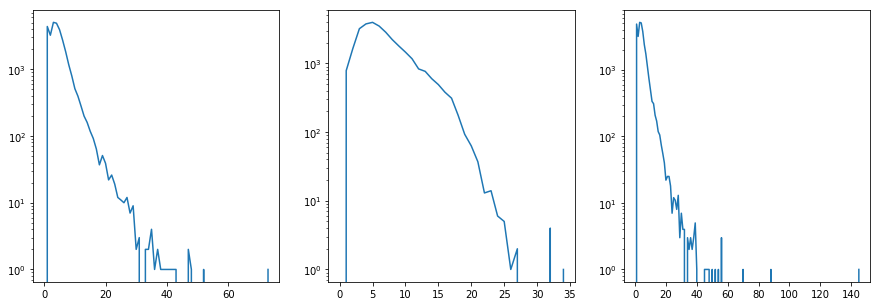

In [8]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(range(max_len[0] + 1), hl[0])
plt.yscale('log')

plt.subplot(1,3,2)
plt.plot(range(max_len[1] + 1), hl[1])
plt.yscale('log')

plt.subplot(1,3,3)
plt.plot(range(max_len[2] + 1), hl[2])
plt.yscale('log')

max_len = [40, 34, 40]

In [9]:
for i in range(len(Xtrain)):
    for j in range(len(Xtrain[i])):
        for k in range(len(Xtrain[i][j])):
            if Xtrain[i][j][k] not in wv_data.keys():
                Xtrain[i][j][k] = wv_id['<unk>']
            else:
                Xtrain[i][j][k] = wv_id[Xtrain[i][j][k]]
        Xtrain[i][j] = Xtrain[i][j][:max_len[i]]
        Xtrain[i][j] += [wv_id['<pad>']] * (max_len[i] - len(Xtrain[i][j]))
        #Xtrain[i][j] = np.array(Xtrain[i][j])
    Xtrain[i] = np.array(Xtrain[i])
#Xtrain = np.array(Xtrain)
#print(Xtrain.shape)
print(Xtrain[0].shape)

for i in range(len(Xtest)):
    for j in range(len(Xtest[i])):
        for k in range(len(Xtest[i][j])):
            if Xtest[i][j][k] not in wv_data.keys():
                Xtest[i][j][k] = wv_id['<unk>']
            else:
                Xtest[i][j][k] = wv_id[Xtest[i][j][k]]
        Xtest[i][j] = Xtest[i][j][:max_len[i]]
        Xtest[i][j] += [wv_id['<pad>']] * (max_len[i] - len(Xtest[i][j]))
        #Xtrain[i][j] = np.array(Xtrain[i][j])
    Xtest[i] = np.array(Xtest[i])
#Xtrain = np.array(Xtrain)
#print(Xtrain.shape)
print(Xtest[0].shape)

(30160, 40)
(2755, 40)


In [10]:
X0_train, X0_test, X1_train, X1_test, X2_train, X2_test, y_train, y_test = \
    train_test_split(Xtrain[0], Xtrain[1], Xtrain[2], Ytrain, test_size=0.2)
X_train = [X0_train, X1_train, X2_train]
X_test = [np.concatenate((X0_test, Xtest[0]), axis=0),
          np.concatenate((X1_test, Xtest[1]), axis=0),
          np.concatenate((X2_test, Xtest[2]), axis=0)]
y_test = np.concatenate((y_test, Ytest), axis=0)

print(X_train[0].shape, y_train.shape)
print(X_test[0].shape, y_test.shape)

(24128, 40) (24128, 4)
(8787, 40) (8787, 4)


# Deep Learning

In [11]:
import matplotlib
def generate_plot(H, nb_epoch):
    print("Generating plots...")
    sys.stdout.flush()
    matplotlib.use("Agg")
    matplotlib.pyplot.style.use("ggplot")
    matplotlib.pyplot.figure()
    N = nb_epoch
    matplotlib.pyplot.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    matplotlib.pyplot.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    matplotlib.pyplot.title("Training Loss on diabetic retinopathy detection")
    matplotlib.pyplot.xlabel("Epoch #")
    matplotlib.pyplot.ylabel("Loss")
    matplotlib.pyplot.legend(loc="lower left")

    matplotlib.pyplot.figure()
    matplotlib.pyplot.plot(np.arange(0, N), H.history["acc"], label="train_acc")
    matplotlib.pyplot.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
    matplotlib.pyplot.title("Training Accuracy on diabetic retinopathy detection")
    matplotlib.pyplot.xlabel("Epoch #")
    matplotlib.pyplot.ylabel("Accuracy")
    matplotlib.pyplot.legend(loc="lower left")

In [12]:
tmp_train = np.asarray(Ytrain).argmax(axis=-1)
unique, counts = np.unique(tmp_train, return_counts=True)
dict(zip(unique, counts))

{0: 14948, 1: 5506, 2: 5463, 3: 4243}

In [13]:
def get_RNN(unit=LSTM, cells=64, bi=False, return_sequences=True, dropout_U=0.,
            consume_less='cpu', l2_reg=0):
    rnn = unit(cells, return_sequences=return_sequences,
               consume_less=consume_less, dropout_U=dropout_U,
               W_regularizer=l2(l2_reg))
    if bi:
        return Bidirectional(rnn)
    else:
        return rnn

In [14]:
#dic = {'negative': 0, 'neutral': 1, 'positive': 2}
dic = {'others': 0, 'angry': 1, 'sad': 2, 'happy': 3}

metrics = {
    "f1_pn": (lambda y_test, y_pred:
              f1_score(y_test, y_pred, average='macro',
                       labels=[dic['happy'],
                               dic['sad'],
                               dic['angry'],
                               dic['others']])),
    "M_recall": (
        lambda y_test, y_pred: recall_score(y_test, y_pred, average='macro')),
    "M_precision": (
        lambda y_test, y_pred: precision_score(y_test, y_pred,
                                               average='macro')),
    "pearson": (
        lambda y_test, y_pred: scipy.stats.pearsonr(y_test, y_pred)[0])
}

#classes = ['positive', 'negative', 'neutral']
#class_to_cat_mapping = get_labels_to_categories_map(classes)
#cat_to_class_mapping = {v: k for k, v in
#                        get_labels_to_categories_map(classes).items()}



plotting = PlottingCallback(grid_ranges=(0.5, 0.75), height=5,
                            benchmarks={"SE17": 0.681})

#_callbacks = []
#_callbacks.append(metrics_callback)
#_callbacks.append(plotting)

checkpointer = ModelCheckpoint(filepath='modelv2.{epoch:02d}-{val_loss:.2f}.hdf5',
                               monitor='val.macro_recall', mode="max",
                               verbose=1, save_best_only=False)
#_callbacks.append(checkpointer)

_datasets = {}
_datasets["1-train"] = (X_train, y_train)
_datasets["2-val"] = (X_test, y_test)
metrics_callback = MetricsCallback(datasets=_datasets, metrics=metrics)
    
    
_callbacks = [metrics_callback, checkpointer]

In [15]:
'''
kfold = StratifiedKFold(n_splits=10, shuffle=True)
X = np.array(Xtrain)
Y = np.array(Ytrain)

for train, test in kfold.split(X, Y):
    _datasets = {}
    _datasets["1-train"] = (X[train], Y[train])
    _datasets["2-val"] = (X[test], Y[test])
    metrics_callback = MetricsCallback(datasets=_datasets, metrics=metrics)
    _callbacks = [metrics_callback]
    
    model.compile(optimizer=Adam(clipnorm=clipnorm, lr=lr), loss='categorical_crossentropy',
                  metrics=['mae', 'accuracy'])
    class_weights = get_class_weights2(onehot_to_categories(Ytrain), smooth_factor=0)
    H = model.fit(X[train], Y[train], epochs=10, batch_size=50, validation_data=(Xtest, Ytest),
              callbacks=_callbacks);#, class_weight=class_weights);
''';

In [16]:

#embeddings = np.array(list(wv_data.values()))
classes=4
max_length=max_len
unit=GRU #LSTM
layers=2
cells=64 #150
final_size = 100
bidirectional=True
attention="simple"
noise=0.2
final_layer=False
dropout_final=0.2 #0.4
dropout_attention=0.4
dropout_words=0.2
dropout_rnn=0.2
dropout_rnn_U=0.2
clipnorm=1
lr=0.01 #0.001
loss_l2=0.001 #0.0001


'''
model = Sequential()
model.add(Embedding(
            input_dim=embeddings.shape[0],
            output_dim=embeddings.shape[1],
            input_length=max_len,
            trainable=False,
            mask_zero=True,
            weights=[embeddings]
))

if noise > 0:
    model.add(GaussianNoise(noise))
if dropout_words > 0:
    model.add(Dropout(dropout_words))

for i in range(layers):
    rs = (layers > 1 and i < layers - 1) or attention
    model.add(get_RNN(unit, cells, bidirectional, return_sequences=rs,
                      dropout_U=dropout_rnn_U))
    if dropout_rnn > 0:
        model.add(Dropout(dropout_rnn))

if attention == "memory":
    model.add(AttentionWithContext())
    if dropout_attention > 0:
        model.add(Dropout(dropout_attention))
elif attention == "simple":
    model.add(Attention())
    if dropout_attention > 0:
        model.add(Dropout(dropout_attention))

if final_layer:
    model.add(MaxoutDense(100, W_constraint=maxnorm(2)))
    # model.add(Highway())
    if dropout_final > 0:
        model.add(Dropout(dropout_final))

model.add(Dense(classes, activity_regularizer=l2(loss_l2)))
model.add(Activation('softmax'))

model.compile(optimizer=Adam(clipnorm=clipnorm, lr=lr),
              loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
''';

In [17]:
shared_RNN = get_RNN(unit, cells, bi=bidirectional, return_sequences='context',
                         dropout_U=dropout_rnn_U)

shared_RNN2 = get_RNN(unit, 150, bi=bidirectional, return_sequences='simple',
                         dropout_U=dropout_rnn_U)

shared_RNN3 = get_RNN(unit, 64, bi=bidirectional, return_sequences='simple',
                         dropout_U=dropout_rnn_U)


input_turn0 = Input(shape=[max_len[0]], dtype='int32')
input_turn1 = Input(shape=[max_len[1]], dtype='int32')
input_turn2 = Input(shape=[max_len[2]], dtype='int32')


# Embeddings
turn0_emb = Embedding(
    input_dim=embeddings.shape[0],
    output_dim=embeddings.shape[1],
    input_length=max_len[0],
    trainable=False,
    mask_zero=True,
    weights=[embeddings]
)(input_turn0)
turn0_emb = GaussianNoise(noise)(turn0_emb)
turn0_emb = Dropout(dropout_words)(turn0_emb)


turn1_emb = Embedding(
    input_dim=embeddings.shape[0],
    output_dim=embeddings.shape[1],
    input_length=max_len[1],
    trainable=False,
    mask_zero=True,
    weights=[embeddings]
)(input_turn1)
turn1_emb = GaussianNoise(noise)(turn1_emb)
turn1_emb = Dropout(dropout_words)(turn1_emb)

turn2_emb = Embedding(
    input_dim=embeddings.shape[0],
    output_dim=embeddings.shape[1],
    input_length=max_len[2],
    trainable=False,
    mask_zero=True,
    weights=[embeddings]
)(input_turn2)
turn2_emb = GaussianNoise(noise)(turn2_emb)
turn2_emb = Dropout(dropout_words)(turn2_emb)


# Recurrent NN
h_turn0 = shared_RNN(turn0_emb)
h_turn0 = Dropout(dropout_rnn_U)(h_turn0)
h_turn0 = shared_RNN2(turn0_emb)
h_turn0 = Dropout(dropout_rnn_U)(h_turn0)
h_turn0 = shared_RNN3(turn0_emb)
h_turn0 = Dropout(dropout_rnn_U)(h_turn0)

h_turn1 = shared_RNN(turn1_emb)
h_turn1 = Dropout(dropout_rnn_U)(h_turn1)
h_turn1 = shared_RNN2(turn1_emb)
h_turn1 = Dropout(dropout_rnn_U)(h_turn1)
h_turn1 = shared_RNN3(turn1_emb)
h_turn1 = Dropout(dropout_rnn_U)(h_turn1)

h_turn2 = shared_RNN(turn2_emb)
h_turn2 = Dropout(dropout_rnn_U)(h_turn2)
h_turn2 = shared_RNN2(turn2_emb)
h_turn2 = Dropout(dropout_rnn_U)(h_turn2)
h_turn2 = shared_RNN3(turn2_emb)
h_turn2 = Dropout(dropout_rnn_U)(h_turn2)

print(h_turn0.shape, h_turn1.shape, h_turn2.shape)

representation = concatenate([h_turn0, h_turn1, h_turn2], axis=1)
representation = AttentionWithContext()(representation)
representation = Dense(final_size, activation='linear')(representation)
representation = Dropout(dropout_final)(representation)

probabilities = Dense(classes, activation="softmax", activity_regularizer=l2(loss_l2))(representation)

model = Model(input=[input_turn0, input_turn1, input_turn2], output=probabilities)

model.compile(optimizer=Adam(clipnorm=clipnorm, lr=lr),
              loss='categorical_crossentropy', metrics=['mae', 'accuracy'])

model.summary()

/home/arthur/anaconda3/envs/dlnlp/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(64, return_sequences="context", kernel_regularizer=<keras.reg..., recurrent_dropout=0.2, implementation=0)`
  """
/home/arthur/anaconda3/envs/dlnlp/lib/python3.6/site-packages/keras/layers/recurrent.py:1605: UserWarning: `implementation=0` has been deprecated, and now defaults to `implementation=1`.Please update your layer call.
  warnings.warn('`implementation=0` has been deprecated, '
/home/arthur/anaconda3/envs/dlnlp/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(150, return_sequences="simple", kernel_regularizer=<keras.reg..., recurrent_dropout=0.2, implementation=0)`
  """
/home/arthur/anaconda3/envs/dlnlp/lib/python3.6/site-packages/keras/layers/recurrent.py:1605: UserWarning: `implementation=0` has been deprecated, and now defaults to `implementation=1`.Please update 

(?, ?, 128) (?, ?, 128) (?, ?, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 300)      197437500   input_1[0][0]                    
_________________________________________________________________________

/home/arthur/anaconda3/envs/dlnlp/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [19]:
nb_epoch = 10
H = model.fit(X_train, y_train, epochs=nb_epoch, batch_size=50, validation_data=(X_test, y_test),
              callbacks=_callbacks);

Train on 24128 samples, validate on 8787 samples
Epoch 1/10
24128/24128 [==============================] - 236s 10ms/step - loss: 0.6058 - mean_absolute_error: 0.1446 - acc: 0.7982 - val_loss: 0.5120 - val_mean_absolute_error: 0.1130 - val_acc: 0.8432
         M_precision  M_recall     f1_pn   pearson
1-train     0.838164  0.820977  0.826531  0.733631
2-val       0.805377  0.811005  0.804983  0.707913


Epoch 00001: saving model to modelv2.01-0.51.hdf5
Epoch 2/10
24128/24128 [==============================] - 240s 10ms/step - loss: 0.5679 - mean_absolute_error: 0.1337 - acc: 0.8144 - val_loss: 0.5272 - val_mean_absolute_error: 0.1229 - val_acc: 0.8403
         M_precision  M_recall     f1_pn   pearson
1-train     0.839439  0.863784  0.850272  0.761698
2-val       0.780497  0.846374  0.808743  0.714535


Epoch 00002: saving model to modelv2.02-0.53.hdf5
Epoch 3/10
24128/24128 [==============================] - 238s 10ms/step - loss: 0.5484 - mean_absolute_error: 0.1294 - acc: 0.8198 - v

RuntimeError: Unable to flush file's cached information (file write failed: time = Thu Dec 13 18:38:32 2018
, filename = 'modelv2.05-0.54.hdf5', file descriptor = 58, errno = 28, error message = 'No space left on device', buf = 0x556d70bf9570, total write size = 6144, bytes this sub-write = 6144, bytes actually written = 18446744073709551615, offset = 4096)

Generating plots...


/home/arthur/anaconda3/envs/dlnlp/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  """
/home/arthur/anaconda3/envs/dlnlp/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/arthur/anaconda3/envs/dlnlp/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


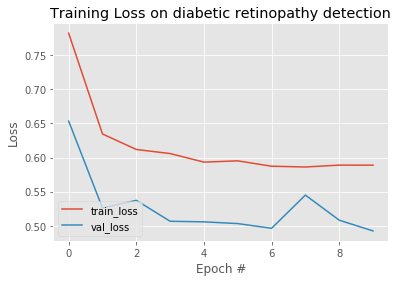

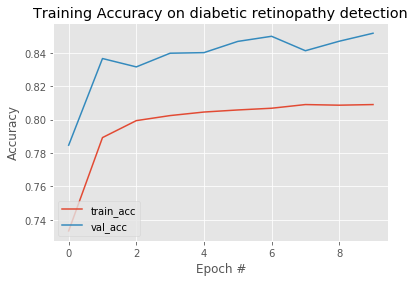

In [24]:
generate_plot(H, nb_epoch)

In [10]:
loaded_model = None
with CustomObjectScope({'Attention': Attention, 'AttentionWithContext': AttentionWithContext}):
    loaded_model = load_model('modelv2.04-0.49.hdf5')

#loaded_model = Model(input=[input_turn0, input_turn1, input_turn2], output=probabilities)
#weights = load_model('model.02-0.53.hdf5', custom_objects={'Attention': Attention, 'AttentionWithContext': AttentionWithContext}).get_weights()
#loaded_model.set_weights(weights)


In [11]:
res = loaded_model.predict(Xtest)

In [20]:
from keras.utils import np_utils

dic = {'others': 0, 'angry': 1, 'sad': 2, 'happy': 3}

f1_score(Ytest, np_utils.to_categorical(np.argmax(res, axis=1)), average='macro',
         labels=[dic['happy'], dic['sad'],
                 dic['angry'], dic['others']])

0.6859785830616255

In [19]:
true = [0, 1, 0, 0, 1, 0]
pred = [0, 0, 1, 0, 0, 1]
f1_score(true, pred, average='macro')

0.25

In [22]:
dic_inv = {0: 'others', 1: 'angry', 2: 'sad', 3: 'happy'}
res_txt = list(map(lambda r: dic_inv[np.argmax(r)], res))
res_txt[:5]

['angry', 'others', 'happy', 'others', 'angry']

In [23]:
df = pd.read_csv('../data/test.txt', sep='\t', index_col=0)
df['label'] = res_txt
df.head()
df.to_csv('submit1.txt', sep='\t')

In [68]:
Xtest[2].shape

(2755, 40)

In [13]:
loaded_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 300)      197437500   input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
gaussian_noise_2 (GaussianNoise (None, 34, 300)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
embedding_